# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = os.getcwd() # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: C:\Users\rjame\Documents\WSWC Documents\MappingStatesDataToWaDE2.0\Montana\Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.csv')
dfs = pd.read_csv('ProcessedInputData/wr_sites.csv')

C:\Users\rjame\AppData\Local\Temp\ipykernel_14592\1076374736.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = pd.read_csv('ProcessedInputData/wr_sites.csv')


In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Surface Water']
58


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,MTre_RUMTre1,4326,Northeast,MTre1,NaN,Conservation Districts,9/21/2021,MT,POLYGON ((-106.15193250999994 48.8564481090000...,MTre_RO1,Surface Water


In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['WaDE Unspecified' 'Surface Water' 'Groundwater']
536630


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,MTwr_SPOD124705,NaN,MTwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,Lewis And Clark,4326,NaN,NaN,100301000000.00000,NaN,46.65274,-111.69757,NaN,NaN,POD,WaDE Unspecified,POD124705,NaN,Well,MT,NaN,MTwr_WSwadeID1,WaDE Unspecified


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data #1

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Conservation Districts" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

58
['Surface Water']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,MTre_RUMTre1,4326,Northeast,MTre1,NaN,Conservation Districts,9/21/2021,MT,POLYGON ((-106.15193250999994 48.8564481090000...,MTre_RO1,Surface Water


<GeoAxesSubplot: >

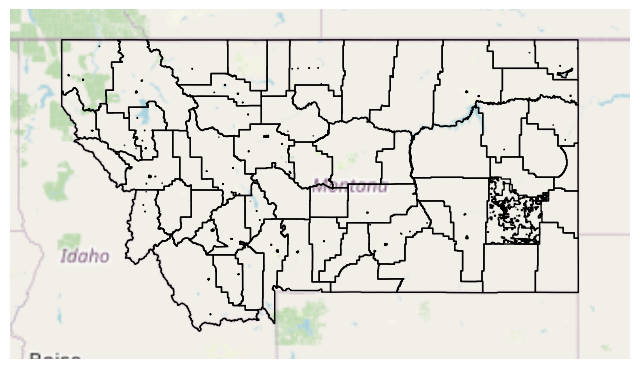

In [7]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
nameOfWaterSourceTypeCV= "Surface Water" # change here for WaterSourceTypeCV of interest
dfs1 = dfs1[dfs1['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

10237
['Surface Water']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
99439,MTwr_SPOD258253,NaN,MTwr_WSwadeID18464,WaDE Unspecified,WaDE Unspecified,Musselshell,4326,NaN,NaN,100700000000.00000,NaN,46.19121,-108.56724,NaN,NaN,POD,WaDE Unspecified,POD258253,NaN,Flowing,MT,NaN,MTwr_WSwadeID18464,Surface Water


<GeoAxesSubplot: >

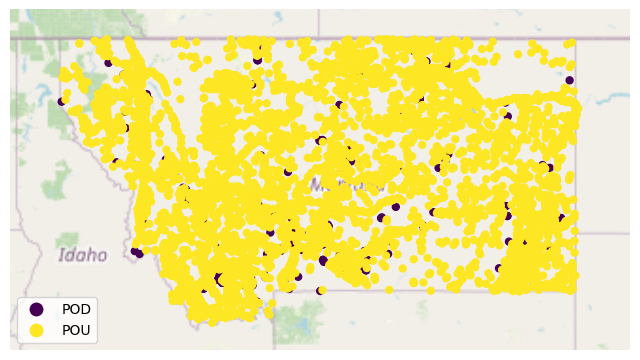

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [11]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

10082


C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
99439,MTwr_SPOD258253,,MTwr_WSwadeID18464,WaDE Unspecified,WaDE Unspecified,Musselshell,4326,,,100700000000.00000,,46.19121,-108.56724,,,POD,WaDE Unspecified,POD258253,,Flowing,MT,,MTwr_WSwadeID18464,Surface Water,POINT (-108.56724 46.19121),8,MTre_RUMTre17,MTre_RO17
99440,MTwr_SPOD258254,,MTwr_WSwadeID18464,WaDE Unspecified,WaDE Unspecified,Musselshell,4326,,,100700000000.00000,,46.20389,-108.54848,,,POD,WaDE Unspecified,POD258254,,Livestock Direct From Source,MT,,MTwr_WSwadeID18464,Surface Water,POINT (-108.54848 46.20389),8,MTre_RUMTre17,MTre_RO17
465606,MTwr_SPOD884005,,MTwr_WSwadeID18464,WaDE Unspecified,WaDE Unspecified,Musselshell,4326,,,100402000000.00000,,46.37233,-108.22419,,,POD,WaDE Unspecified,POD884005,,Livestock Direct From Source,MT,,MTwr_WSwadeID18464,Surface Water,POINT (-108.22419 46.37233),8,MTre_RUMTre17,MTre_RO17
524050,MTwr_SPOU102175,,MTwr_WSwadeID17788,WaDE Unspecified,Centroid of Area,MUSSELSHELL,4326,"POLYGON ((-108.862851967028 46.6924464246034, ...",,,,46.68514,-108.85239,,,POU,WaDE Unspecified,POU102175,,WaDE Unspecified,MT,,MTwr_WSwadeID17788,Surface Water,POINT (-108.85239 46.68514),8,MTre_RUMTre17,MTre_RO17
524563,MTwr_SPOU112,,MTwr_WSwadeID19486,WaDE Unspecified,Centroid of Area,MUSSELSHELL,4326,"POLYGON ((-108.573621608855 46.7293904053328, ...",,,,46.73029,-108.57230,,,POU,WaDE Unspecified,POU112,,WaDE Unspecified,MT,,MTwr_WSwadeID19486,Surface Water,POINT (-108.57230 46.73029),8,MTre_RUMTre17,MTre_RO17


<GeoAxesSubplot: >

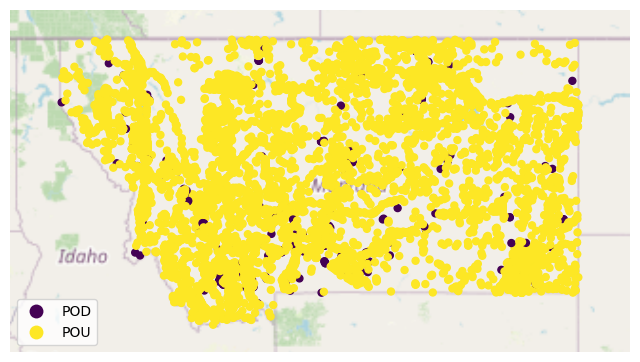

In [12]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [13]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
99439,MTwr_SPOD258253,MTre_RO17,MTwr_WSwadeID18464,WaDE Unspecified,WaDE Unspecified,Musselshell,4326,,,100700000000.00000,,46.19121,-108.56724,,,POD,WaDE Unspecified,POD258253,,Flowing,MT,


#### Regulatory Area Data #2

In [14]:
# dfru2 = dfru.copy()
# etc etc

## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [15]:
# Concatenate dataframes into single output
frames = [dfs, gdfs1_ru1] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem!=''])).replace(np.nan, "").reset_index(drop=True)
print(len(outdfs))

536630


# Inspect Output Data & Export

In [16]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536630 entries, 0 to 536629
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   RegulatoryOverlayUUIDs  536630 non-null  object
 1   WaterSourceUUIDs        536630 non-null  object
 2   CoordinateAccuracy      536630 non-null  object
 3   CoordinateMethodCV      536630 non-null  object
 4   County                  536630 non-null  object
 5   EPSGCodeCV              536630 non-null  object
 6   Geometry                536630 non-null  object
 7   GNISCodeCV              536630 non-null  object
 8   HUC12                   536630 non-null  object
 9   HUC8                    536630 non-null  object
 10  Latitude                536630 non-null  object
 11  Longitude               536630 non-null  object
 12  NHDNetworkStatusCV      536630 non-null  object
 13  NHDProductCV            536630 non-null  object
 14  PODorPOUSite            536630 non-n

In [17]:
outdfs

,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,,MTwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,Lewis And Clark,4326,,,100301000000.0,,46.65273768,-111.6975724,,,POD,WaDE Unspecified,POD124705,,Well,MT,,MTwr_WSwadeID1,WaDE Unspecified
1,,MTwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,Powder River,4326,,,100902000000.0,,45.02666554,-105.8787068,,,POD,WaDE Unspecified,POD124706,,Well,MT,,MTwr_WSwadeID1,WaDE Unspecified
2,,MTwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,Powder River,4326,,,100902000000.0,,45.02666554,-105.8787068,,,POD,WaDE Unspecified,POD124707,,Well,MT,,MTwr_WSwadeID1,WaDE Unspecified
3,,MTwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,Lewis And Clark,4326,,,100301000000.0,,46.6434767,-111.6978111,,,POD,WaDE Unspecified,POD124708,,Well,MT,,MTwr_WSwadeID1,WaDE Unspecified
4,,MTwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,Granite,4326,,,170102000000.0,,46.32126723,-113.2996352,,,POD,WaDE Unspecified,POD124709,,Well,MT,,MTwr_WSwadeID1,WaDE Unspecified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536625,,MTwr_WSwadeID17748,WaDE Unspecified,Centroid of Area,CASCADE,4326,"POLYGON ((-111.933500513125 47.4931801513195, ...",,,,47.49409141,-111.9321665,,,POU,WaDE Unspecified,POU993,,WaDE Unspecified,MT,,MTwr_WSwadeID17748,Groundwater
536626,,MTwr_WSwadeID17748,WaDE Unspecified,Centroid of Area,FERGUS,4326,"POLYGON ((-109.809592844781 47.4901558098572, ...",,,,47.49741797,-109.7988973,,,POU,WaDE Unspecified,POU993266,,WaDE Unspecified,MT,,MTwr_WSwadeID17748,Groundwater
536627,MTre_RO29,MTwr_WSwadeID18220,WaDE Unspecified,Centroid of Area,SANDERS,4326,"POLYGON ((-114.293424767175 47.3233920489905, ...",,,,47.32520553,-114.2907873,,,POU,WaDE Unspecified,POU997060,,WaDE Unspecified,MT,,MTwr_WSwadeID18220,Surface Water
536628,,MTwr_WSwadeID17748,WaDE Unspecified,Centroid of Area,DAWSON,4326,"POLYGON ((-105.069363735571 47.021961108175, -...",,,,47.01466356,-105.059175,,,POU,WaDE Unspecified,POU997289,,WaDE Unspecified,MT,,MTwr_WSwadeID17748,Groundwater


In [18]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder